In [11]:
from pymongo import MongoClient
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from wsba import *
%matplotlib inline
from datetime import timedelta

In [12]:
# Pilfered from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(
    #font='Franklin Gothic Book',
    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'lightgrey',
         'axes.facecolor': 'None',
         'axes.grid': False,
         'axes.labelcolor': 'dimgrey',
         'axes.spines.right': False,
         'axes.spines.top': False,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'w',
         'patch.force_edgecolor': True,
         'text.color': 'dimgrey',
         'xtick.bottom': True,
         'xtick.color': 'dimgrey',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgrey',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})


In [14]:
getnumsubmissions()

1719

In [15]:
findone()

"{'_id': ObjectId('605bb15d5df7eedfb49c1b8b'), 'id': 'mcheu3', 'fullname': 't3_mcheu3', 'selftext': '', 'created_utc': '2021-03-24 17:38:13', 'num_comments': 0, 'score': 1, 'upvote_ratio': 1.0, 'is_original_content': False, 'permalink': '/r/wallstreetbets/comments/mcheu3/ill_just_blame_it_on_my_wifes_bf_those_16_shares/', 'title': 'I’ll just blame it on my wife’s bf. Those 16 shares came from his account . 🦍 🍌 🤡 honk honk . 🍦 ICE-CREAM !!! When the —— did we get ice-cream !', 'author': 'DaveThePOKEMONGuy', 'firstseen': '2021-03-24 21:38:37.006766'}"

Here is raw mongo to sort by date:
```    
db.wsb_submissions.aggregate( [ {
   $project: {
      'date': {
         $dateFromString: {
            dateString: '$created_utc'
         }
      }
   }
}, { $sort: { 'date' : 1} } ] )
```


In [16]:
date_sorted = wsbs.aggregate( [ {
   '$project': {
      'date': {
         '$dateFromString': {
            'dateString': '$created_utc'
         }
      }
   }
}, { '$sort': { 'date' : 1} } ] )

In [17]:
for x in date_sorted:
    print(x)
    break

{'_id': ObjectId('605bb2fe5df7eedfb49c1f56'), 'date': datetime.datetime(2021, 3, 18, 15, 8, 41)}


In [20]:
def getdaterange():
    first = None
    last = None
    dates_sorted = wsbs.aggregate( [ { '$project': { 'date': { '$dateFromString': 
        { 'dateString': '$created_utc' } } } }, { '$sort': { 'date' : 1} } ] )
    for val in dates_sorted:
        first = val
        break
    dates_sorted = wsbs.aggregate( [ { '$project': { 'date': { '$dateFromString': 
        { 'dateString': '$created_utc' } } } }, { '$sort': { 'date' : -1} } ] )
    for val in dates_sorted:
        last = val
        break
    
    return (first,last)

In [21]:
first,last = getdaterange()
last['date'].strftime('%m/%d/%y')

'04/01/21'

In [22]:
def groupbyauthor(show=False, min=0):
    authors = wsbs.aggregate([{"$group":{"_id":"$author","count": { "$sum":1 }}},{"$sort":{'count':-1}}])
    most = 10
    i = 0
    post_counts = []
    posters = []
    for x in authors:
        if x['count'] > 1 and show:
            print(x)
    
        if x['count'] >= min:
            i += 1
            post_counts.append(x['count'])
            posters.append(x['_id'])
            
    return (i, posters, post_counts)
    

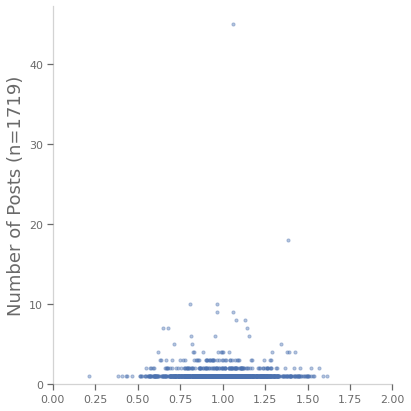

In [27]:
num, posters, post_counts = groupbyauthor()


fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(x=stats.norm.rvs(1,size=len(post_counts),scale=.2),
           y=post_counts,
           s=10,
           alpha=.4)
ax.set_ylabel(f'Number of Posts (n={sum(post_counts)})')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0,xmax=2)
plt.tight_layout()
#plt.savefig('figures/pda_numposts.png')

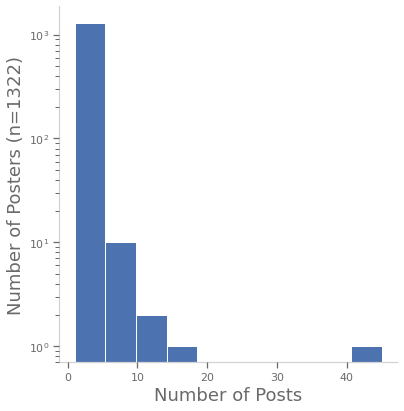

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(x=post_counts)
ax.set_ylabel(f'Number of Posters (n={num})')
ax.set_xlabel('Number of Posts')
plt.tight_layout()
plt.yscale('log')
#plt.savefig('figures/pda_numposts_hist.png')

[1511, 161, 828, 1049, 0, 2020, 1547, 2380, 52, 934, 1205, 3177, 2381, 526, 1298, 1395, 3227, 749, 204, 3707, 710, 1078, 211, 100, 394, 1089, 635, 2952, 231, 416, 161, 51, 169, 116, 66, 108, 1029, 1419, 1100, 213, 195, 3, 88, 67, 361, 285, 220, 15, 116, 192, 884, 554, 1194, 420, 1564, 313, 182, 166, 174, 37, 376, 83, 76, 362, 786, 66, 179, 228, 10, 760, 17, 19, 209, 277, 118, 45, 44, 162, 117, 151, 29, 808, 743, 40, 0, 22, 591, 170, 161, 244, 206, 213, 412, 20, 258, 163, 715, 1391, 3, 104]


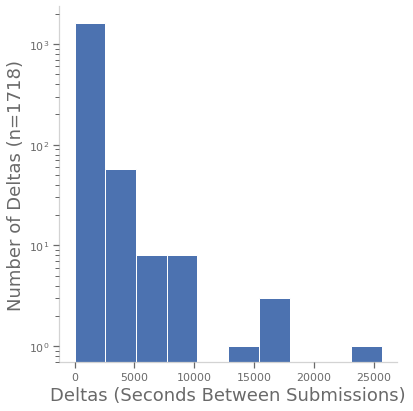

In [46]:
def getsubmissiondeltas():
    submission_dates = wsbs.aggregate( [ {
        '$project': {
            'date': {
                '$dateFromString': {
                    'dateString': '$created_utc'
                 }
             }
        }
    }, { '$sort': { 'date' : -1} } ] )
    
    i = 0
    lastTime = None
    deltas = []
    for x in submission_dates:
        i += 1
        if lastTime != None:
            delta = (lastTime - x['date']).seconds
            deltas.append(delta)
        #print(i, x)
        lastTime = x['date']
        #if i >= 30:
        #    break
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.hist(x=deltas)
    ax.set_ylabel(f'Number of Deltas (n={len(deltas)})')
    ax.set_xlabel('Deltas (Seconds Between Submissions)')
    plt.tight_layout()
    plt.yscale('log')
    return deltas

deltas = getsubmissiondeltas()
print(deltas[:100])